<a href="https://colab.research.google.com/github/zhouchun0105/BA810_Team1/blob/main/SUBMIT_Bitcoin_Price_and_Movement_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bitcoin Price and Movement Direction Prediction**

Team 1, Morning Session

Chun Zhou, Geech Huot, Ji Qi, Vaibhav Garimella Bhaskara, Yihan Jia, Zheming Xu

# **List of Questions**

**1. Does our dataset have missing data? What are the characteristics of the missing data?**
25% of each column's data is missing. And especially the data from 2011 (99% missing) and 2012 (94% missing) are missing significantly. We tackled the problem by deleting data from certain years and using interpolate to fill in the rest.

**2.	Does the bitcoin price have impacts on missing data rate?**
We notice that when bitcoin price is more stable during earlier years (2011 to 2017), there is a high chance of missing data. When bitcoin price fluctuates and boosts the most (2017 to 2021), there is few missing data.


**3.	Is there any abnormal data occurred? How can we deal with it?**
The return in early 2012 and mid 2016 is abnormal with higher than expected values. We spotted the lowest and highest percentage return and percentage volume and drop the value. According to financial knowledge per minutes fluctuation shouldn’t be as high as 83%.


**4.	Are there any financially meaningful features can be created using currently existing features?**
We create Price, Return, Percentage Return, Bitcoin Price Movement Direction, Percentage Volume and Lag 1,2,3,4,5 factors because these are all significant indicators in any kinds of equities.


**5.	Will the removal of abnormal data and missing values have impacts on our studies?**
We use sklearn.preprocessing.StandardScaler to verify if the change of granularity will affect our dataset. Plots of several time intervals show that the variance or return percentage is constant over time. We may assume that this will not affect our training model.


**6.	How does financial indicators of bitcoin change over the years?**
By plotting time series graphs for each feature, we notice that generally all financial indicators, including Open, High, Low, Close, Average Price, Weighted Price, Volume in Currency, and Volume in Bitcoin increase over the years.


**7.	What’s the major probability of bitcoin price?**
With KDE plot, majority of bitcoin prices range from \$0 to 10k. It’s very rare for bitcoin price to be higher than $20K.


**8.	How is the correlation between each feature?**
The seaborn heatmap shows strong correlation among all types of Price features. Notably volume has relatively stronger correlation with bitcoin price.


**9.	Can we predict bitcoin price with trading volume?**
The scatter plot between bitcoin price and trading volume doesn’t show a strong linear or nonlinear relationship. However, the moving average of 60min and 120min volume has collinearity with bitcoin price over time.


**10.	Can the lag variable from 1 minute lag, 1 hour lag, daily lag, weekly lag and 1-month lag indicate bitcoin price today?**
By plotting different time lag against bitcoin price today, results strongly indicate that the shorter the lag, the stronger indicator it is for bitcoin price prediction.


**11.	Is there a trend for which month in a year bitcoin price is higher than usual?**
By grouping bitcoin price by months, usually bitcoin prices are higher in February and March across the ten years.


**12.	Is Logistics Regression a good model to predict bitcoin price upward or downward movement?**
Logistics Regression model has a high sensitivity and low specificity, which means both model predict the upward movement at a high correct rate, but predict the downward direction at a pretty low correct rate.


**13.	Is Gaussian Naïve Bayes a good model to predict bitcoin price upward or downward movement?**
Gaussian Naive Bayes model shows the model accuracy at 53.96%, which is slightly higher than the Logistic Regression model(53.44%). These two models are not good enough to predict the bitcoins price, since they don't capture any other impacts such as, seasonality, trend, and intrinsic factors.


**14.	What is the effectiveness of ARIMA model?**
 It is not an effective model because the model works best with stationary time series data. We were not able to forecast more than 3 steps for the bitcoin price so it is hard to visualize in comparison with the test data.


**15.	What is the predicted price of ARIMA model?**
The predicted price is $58621 for the next day and the accuracy is around 83%.


**16.	Is Simple RNN a good model to predict bitcoin price?**
We calculated the loss function and the MSE of 100 layers. Since the smallest MSE is 3.7816e-04, combined with the drawn prediction result graph, we can conclude that Simple RNN's prediction fit for the Bitcoin price is relatively good.


**17.	Why is there a gap in the "BTC price prediction" graph of RNN Model?**
The RNN model itself has defects in processing long-term memory. And it has two main obstacles, explosion gradient and vanishing gradient.  So we consider the problem of the model itself, we choose to use the LSTM model to optimize. Secondly, we believe that this gap is caused by event-driven factors in the news, and the following LSTM model also confirms our conjecture.


**18.	Does LSTM model predicts bitcoin price accurately?**
The model predicts prices on 200 values and fitted 100 times. The results were not accurate, but we saw that, in the data before 2007, the price difference between the prediction and the actual was less when compared to the data after 2007.  This we can say that the model is sustainable when there is no volatile price changes.


# **Data Souces**

Dr. Mark Zielinski (Brandeis University) perfomed data scraping from bitstamp

https://www.bitstamp.net/?gclid=CjwKCAjw4qCKBhAVEiwAkTYsPNsiJrj6svNLLPy3HMEyoxVQTQeWObFBVSOFJxZ2CP1yabYZTBv7JhoCgfoQAvD_BwE

Kaggle url(for data download): https://www.kaggle.com/mczielinski/bitcoin-historical-data

More real-time bitcoin data can be found at https://bitcoincharts.com

# **Project Objective**

Our goal is to predict bitcoin movement direction and exact price at a certain time. We will perform exploratory data analysis of bitcoin price (per seconds) time series from 2012 to 2021 with 16 attributes and 5 million rows. We will predict bitcoin price movement direction using logistics regression and Gaussian Naive Bayes. We will also predict bitcoin price using ARIMA, Simple RNN and LSTM models to select the best fit.


# **Contents**


*   Data Cleaning
*   Feature Engineering
*   Exploratory Data Analysis
*   Logistics Regression
*   Gaussian Naive Bayes
*   ARIMA Model
*   Simple RNN
*   LSTM




# **Import Packages**

In [ ]:
!pip install keras-tuner --upgrade
!pip install pmdarima

     |████████████████████████████████| 97 kB 5.5 MB/s 
     |████████████████████████████████| 1.4 MB 16.0 MB/s 
     |████████████████████████████████| 9.8 MB 28.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import os

import numpy as np
from numpy import log
import pandas as pd
import datetime as datetime

pd.set_option('mode.chained_assignment', None)
pd.set_option("display.max_columns", 100)

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

from sklearn.linear_model import LogisticRegression   # choose model class
model = LogisticRegression(solver='liblinear')       # instantiate model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras import models, layers



from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.arima_model as stats

import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]

import tensorflow as tf
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, LSTM, Dropout, Flatten
import keras_tuner as kt
from tensorflow import keras
from keras.callbacks import ModelCheckpoint


In [ ]:
from google.colab import drive 
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [ ]:
os.listdir()

['.config', 'drive', 'sample_data']

#**Data Cleaning**

Import dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/bitcoin.csv")

Change the timestamp to datetime attribute and turn the interval into seconds.

In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')
df = df.set_index('Timestamp')
df

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496


Analyze where the missing values are.

In [ ]:
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]

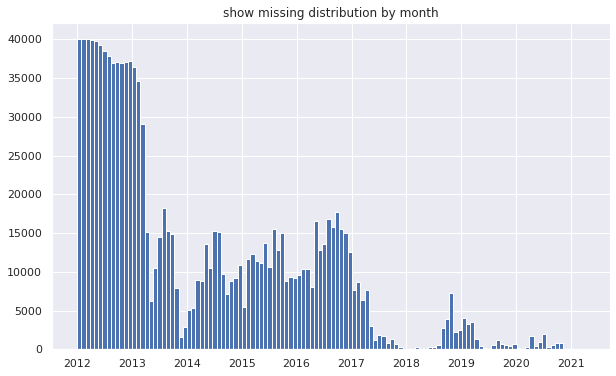

In [ ]:
plt.hist(rows_with_NaN.index,bins=120)
plt.title("show missing distribution by month")
plt.show()

Missing values from 2012 to 2013 is severe and 2014 to 2017 is moderate.

Spot the missing values

In [ ]:
missed = pd.DataFrame()
missed['column'] = df.columns

missed['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]
missed = missed.sort_values('percent',ascending=False)
missed = missed[missed['percent']>0]
missed

,column,percent
0,Open,25.6
1,High,25.6
2,Low,25.6
3,Close,25.6
4,Volume_(BTC),25.6
5,Volume_(Currency),25.6
6,Weighted_Price,25.6


In [ ]:
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]
is_NaN.index = is_NaN.index.year

All columns have the same percentage of missing values. This shows that probably missing values are in the same rows.

Further more analysis of missing data by year

In [ ]:
missing_by_yr = is_NaN.groupby(is_NaN.index).Open.agg('sum').to_frame().join(is_NaN.index.value_counts().to_frame())
missing_by_yr.columns=["Missing_counts", "Total_counts"]
missing_by_yr["Missing rate"] = missing_by_yr.Missing_counts/missing_by_yr.Total_counts
missing_by_yr

,Missing_counts,Total_counts,Missing rate
Timestamp,,,
2011,964,968,0.995868
2012,500411,527040,0.949474
2013,205839,525600,0.391627
2014,127424,525600,0.242435
2015,146393,519128,0.281998
2016,174941,527040,0.331931
2017,42268,525600,0.080419
2018,19827,525600,0.037723
2019,17260,525600,0.032839


Use interpolation to fill missing values.

In [ ]:
def fill_missing(df):
    frame = df.copy(deep=True)
    ### function to impute missing values using interpolation ###
    frame['Open'] = frame['Open'].interpolate()
    frame['Close'] = frame['Close'].interpolate()
    frame['Weighted_Price'] = frame['Weighted_Price'].interpolate()
    frame['Volume_(BTC)'] = frame['Volume_(BTC)'].interpolate()
    frame['Volume_(Currency)'] = frame['Volume_(Currency)'].interpolate()
    frame['High'] = frame['High'].interpolate()
    frame['Low'] = frame['Low'].interpolate()
    return frame


df_inter = fill_missing(df)
df_inter.dropna(inplace=True)
df.dropna(inplace=True)

In [ ]:
print('Orignal dataframe shape is: ' + str(df.shape))
print('Interpolated dataframe shape is: '+ str(df_inter.shape))

Orignal dataframe shape is: (3613769, 7)
Interpolated dataframe shape is: (4857377, 7)


Visualization of bitcoin price move and missing rate over time.

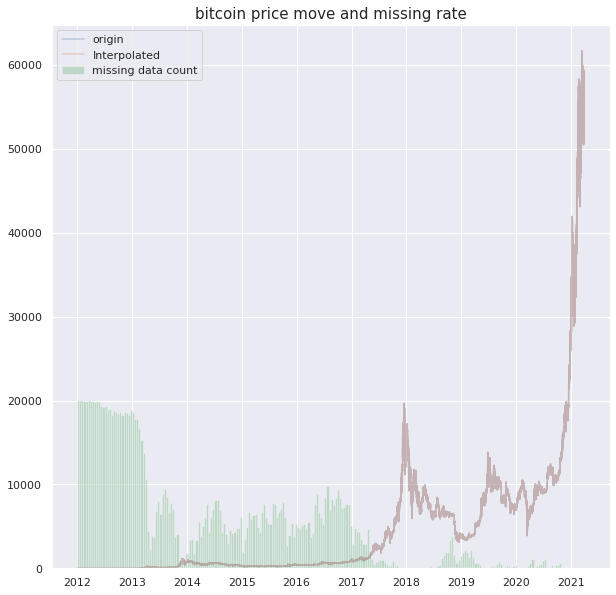

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(df.index, df.Weighted_Price, alpha= 0.3, label='origin')
ax.plot(df_inter.index, df_inter.Weighted_Price, alpha= 0.3, label='Interpolated')
ax.hist(rows_with_NaN.index,bins=240, alpha=0.3, label='missing data count')
ax.legend()
ax.set_title('bitcoin price move and missing rate', fontsize=15)
plt.show()

# **Feature Engineering**

Add a Price column to the dataframe by taking average of Open, High, Low, and Close price columns.

In [ ]:
df["Price"] = df[["Open","High","Low","Close"]].mean(axis=1)


Add Return Column by calculating the difference from now to previous second's Price

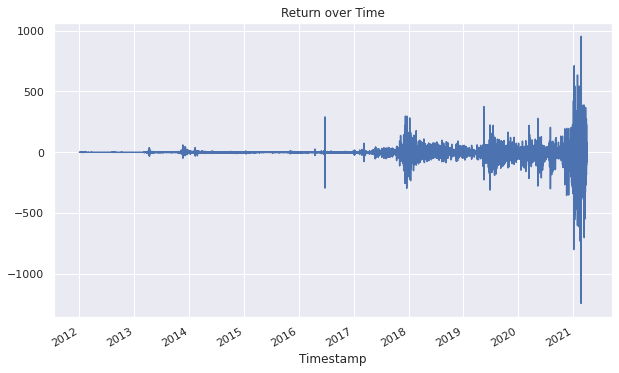

In [ ]:
df["Return"] = df["Price"].diff()
df["Return"].plot(x="Timestamp", y="Return", title="Return over Time")

We can see from the graph that the return fluctuation is the biggest in recent years. We believe that this is due to event driven factors such as Elon Musk's twitter and news on bitcoin over the internet.

Add Direction column showing if bitcoin price is going up or down.

In [ ]:
df["Direction"] = pd.Series(df["Return"] > 0)
df["Direction"] = "Down"
df.loc[(df["Return"] > 0), "Direction"] = "Up"

Add Percentage_Return column to show the perentage return per minutes. We can tell from the graph that there are abnormal values. Usually in-day return is controlled under 10% for stock markets.

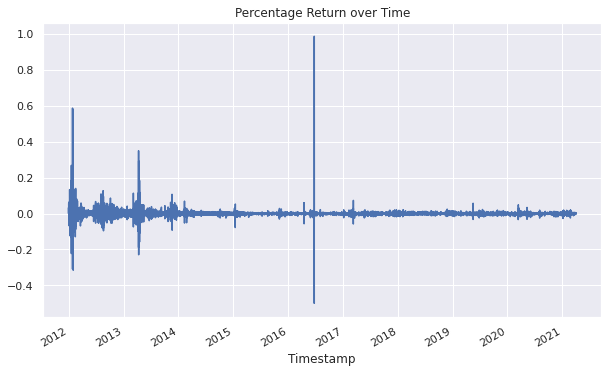

In [ ]:
df["Percentage_Return"] = ((df["Return"].shift(periods=-1))/ (df["Price"])).shift(periods=1)
df["Percentage_Return"].plot(title="Percentage Return over Time")

The percentage return has more fluctuation in earlier years than recent's.

We decide to delete the abnormal values at 1% and 99% because the percentage return per minutes are not expected to be that high. We consider it as weird outliers.

In [ ]:
df["Percentage_Return"] = ((df["Return"].shift(periods=-1))/ (df["Price"])).shift(periods=1)
df["Volume_diff"] = df["Volume_(Currency)"].diff()
df["Percentage_Volume"] = ((df["Volume_diff"].shift(periods=-1))/ (df["Price"])).shift(periods=1)

In [ ]:
low, high = 0.01, 0.99
selected_columns = ["Percentage_Return", "Percentage_Volume"]

quant_df = df[selected_columns].quantile([low, high])
quant_df

,Percentage_Return,Percentage_Volume
0.01,-0.004313,-83.656998
0.99,0.004219,85.030174


In [ ]:
low, high = 0.01, 0.99
selected_columns = ["Percentage_Return"]

quant_df = df[selected_columns].quantile([low, high])

for col in selected_columns:
    df.drop(df[df[col] <= quant_df.loc[low, col]].index, axis=0, inplace=True)
    df.drop(df[df[col] >= quant_df.loc[high, col]].index, axis=0, inplace=True)

Take a look at Percentage_Return image after we remove the abnormal values.

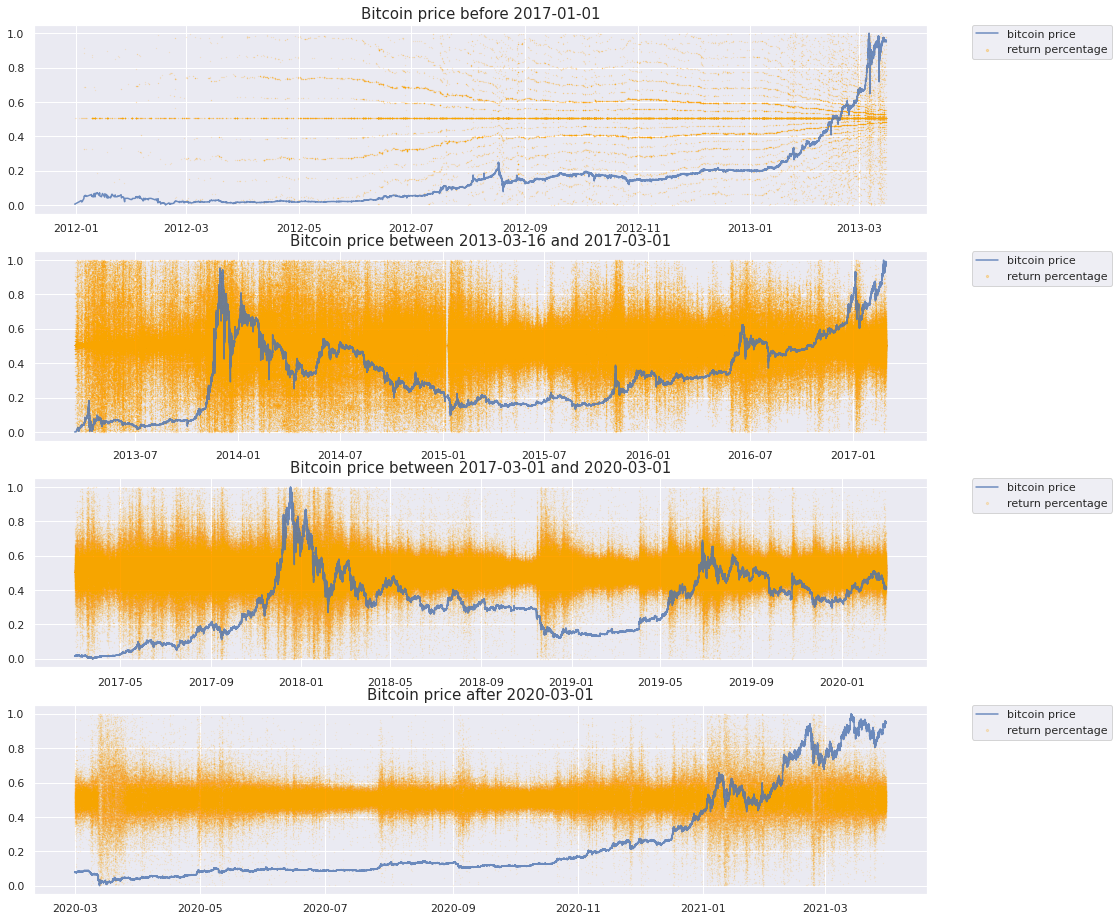

In [ ]:
# Choose the time interval
stamp1 = pd.Timestamp(2013,3,16)
stamp2 = pd.Timestamp(2017,3,1)
stamp3 = pd.Timestamp(2020,3,1)

# Enlarge the label font size
plt.rcParams.update({'font.size': 10})

# Plot the graph
fig, ax = plt.subplots(4, 1,figsize=(16,16))

time_stamp = pd.Timestamp(2017,1,1)
ax[0].plot(df[df.index<stamp1].index, scaler.fit_transform(df[df.index<stamp1].Weighted_Price.values.reshape(-1,1)), alpha=0.8, label="bitcoin price")
ax[0].scatter(df[df.index<stamp1].index, scaler.fit_transform(df[df.index<stamp1].Percentage_Return.values.reshape(-1,1)), s=0.05, c="orange", alpha=0.3, label="return percentage")
ax[0].set_title("Bitcoin price before %s"%time_stamp.strftime('%Y-%m-%d'), fontsize=15)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=10)


ax[1].plot(df[(df.index>stamp1)&(df.index<stamp2)].index, scaler.fit_transform(df[(df.index>stamp1)&(df.index<stamp2)].Weighted_Price.values.reshape(-1,1)), alpha=0.8, label="bitcoin price")
ax[1].scatter(df[(df.index>stamp1)&(df.index<stamp2)].index, scaler.fit_transform(df[(df.index>stamp1)&(df.index<stamp2)].Percentage_Return.values.reshape(-1,1)), s=0.05, c="orange", alpha=0.3, label="return percentage")
ax[1].set_title("Bitcoin price between %s and %s"%(stamp1.strftime('%Y-%m-%d'), stamp2.strftime('%Y-%m-%d')), fontsize=15)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=10)


ax[2].plot(df[(df.index>stamp2)&(df.index<stamp3)].index, scaler.fit_transform(df[(df.index>stamp2)&(df.index<stamp3)].Weighted_Price.values.reshape(-1,1)), alpha=0.8, label="bitcoin price")
ax[2].scatter(df[(df.index>stamp2)&(df.index<stamp3)].index, scaler.fit_transform(df[(df.index>stamp2)&(df.index<stamp3)].Percentage_Return.values.reshape(-1,1)), s=0.05, c="orange", alpha=0.2, label="return percentage")
ax[2].set_title("Bitcoin price between %s and %s"%(stamp2.strftime('%Y-%m-%d'), stamp3.strftime('%Y-%m-%d')), fontsize=15)
ax[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=10)


ax[3].plot(df[df.index>stamp3].index, scaler.fit_transform(df[df.index>stamp3].Weighted_Price.values.reshape(-1,1)), alpha=0.8, label="bitcoin price")
ax[3].scatter(df[df.index>stamp3].index, scaler.fit_transform(df[df.index>stamp3].Percentage_Return.values.reshape(-1,1)), s=0.05, c="orange", alpha=0.2, label="return percentage")
ax[3].set_title("Bitcoin price after %s"%(stamp3.strftime('%Y-%m-%d')), fontsize=15)
ax[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=10)

plt.draw()

Since we removed some abnormal values from the orignal dataset, the granularity is changed. We confirmed this change will not greatly affect our training model that learns from historical data with different time intervals. In general, the variance is stable over time for both graphs.

Add Lag1, Lag2, Lag3, Lag4, Lag5 columns as t-1, t-2, t-3, t-4, and t-5 features to predict bitcoin price at t (in seconds)

In [ ]:
df["Lag1"]= df["Percentage_Return"].shift(periods=-1)
df["Lag2"]= df["Percentage_Return"].shift(periods=-2)
df["Lag3"]= df["Percentage_Return"].shift(periods=-3)
df["Lag4"]= df["Percentage_Return"].shift(periods=-4)
df["Lag5"]= df["Percentage_Return"].shift(periods=-5)

# **Exploratory Data Analysis**

Take a overview on how each attribute varies over time. From the graph, we can tell all the attributes increase over years and boost since 2020.

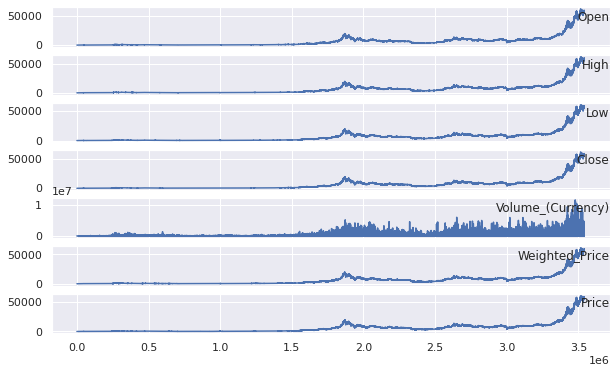

In [ ]:
values = df.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
plt.title("Attributes over Time")
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

Kernal Density Estimate plot of Price shows the approximate distribution of bitcoin prices. We can tell that most Price values are between 0 and 10 thousands USD.

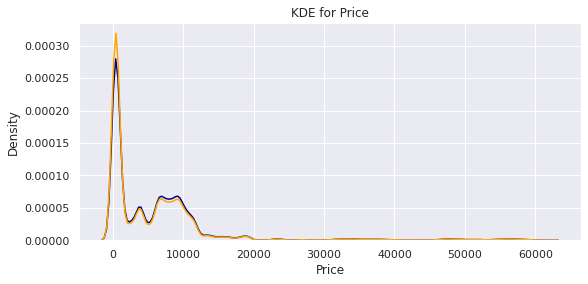

In [ ]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['Direction'] == 'Up'][feature].dropna(), color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(df[df['Direction'] == 'Down'][feature].dropna(), color= 'orange', label= 'Churn: Yes')
kdeplot('Price')

Analyze correlations with seaborn heatmap

Each square shows the correlation between the variables on each axis.The close to 1 the correlation is the more positively correlated they are. As we can see in the graph those which are green, they have a perfect correlation, such as price and open price. For open price and volume(BTC),it has a negative correlation which means if one increase, one will decrease.

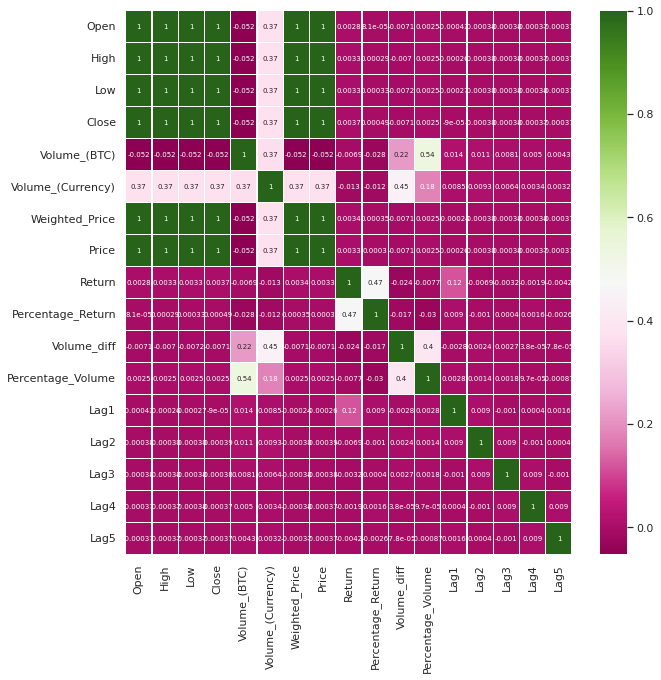

In [ ]:
corr = df.corr()
plt.figure(figsize=[10,10])
plt.rcParams['font.size']=7
sns.heatmap(corr, cmap='PiYG', annot= True, linewidths=0.3 );

We notice that volume may have an impact on bitcoin price. So we first analyze their correlation by a scatter plot.

Text(0.5, 1.0, 'Relationship between Weighted_Price and Volume_Currency')

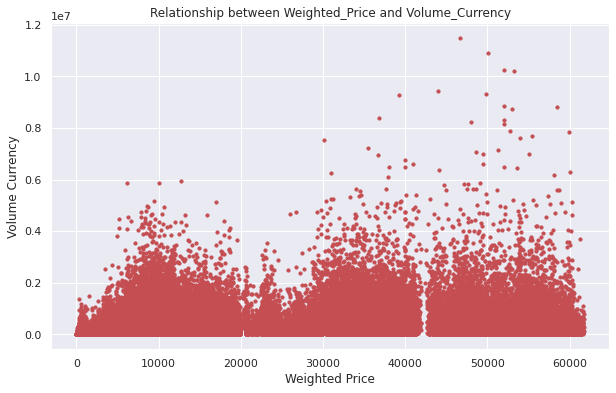

In [ ]:
plt.scatter(df['Weighted_Price'],df['Volume_Currency'],s = 10,c = 'r',marker = 'o')
plt.xlabel('Weighted Price')
plt.ylabel('Volume Currency')
plt.title('Relationship between Weighted_Price and Volume_Currency')


The scatter plot doesn't show a clear correlation.

We want to compare the trend of price with volume per 60min and per 120min. If their movement over time is similar, we could probably predict bitcoin price with volume.

In [ ]:
df.columns = ["Open", "High", "Low","Close", "Volume_BTC", "Volume_Currency", "Weighted_Price","Price","Return","Direction","Percentage_Return","Volume_diff","Percentage_Volume","Lag1","Lag2","Lag3","Lag4","Lag5"]

In [ ]:
df["Vol_MA60"] = df.Volume_Currency.rolling(window=60).sum()
df["Vol_MA120"] = df.Volume_Currency.rolling(window=120).sum()

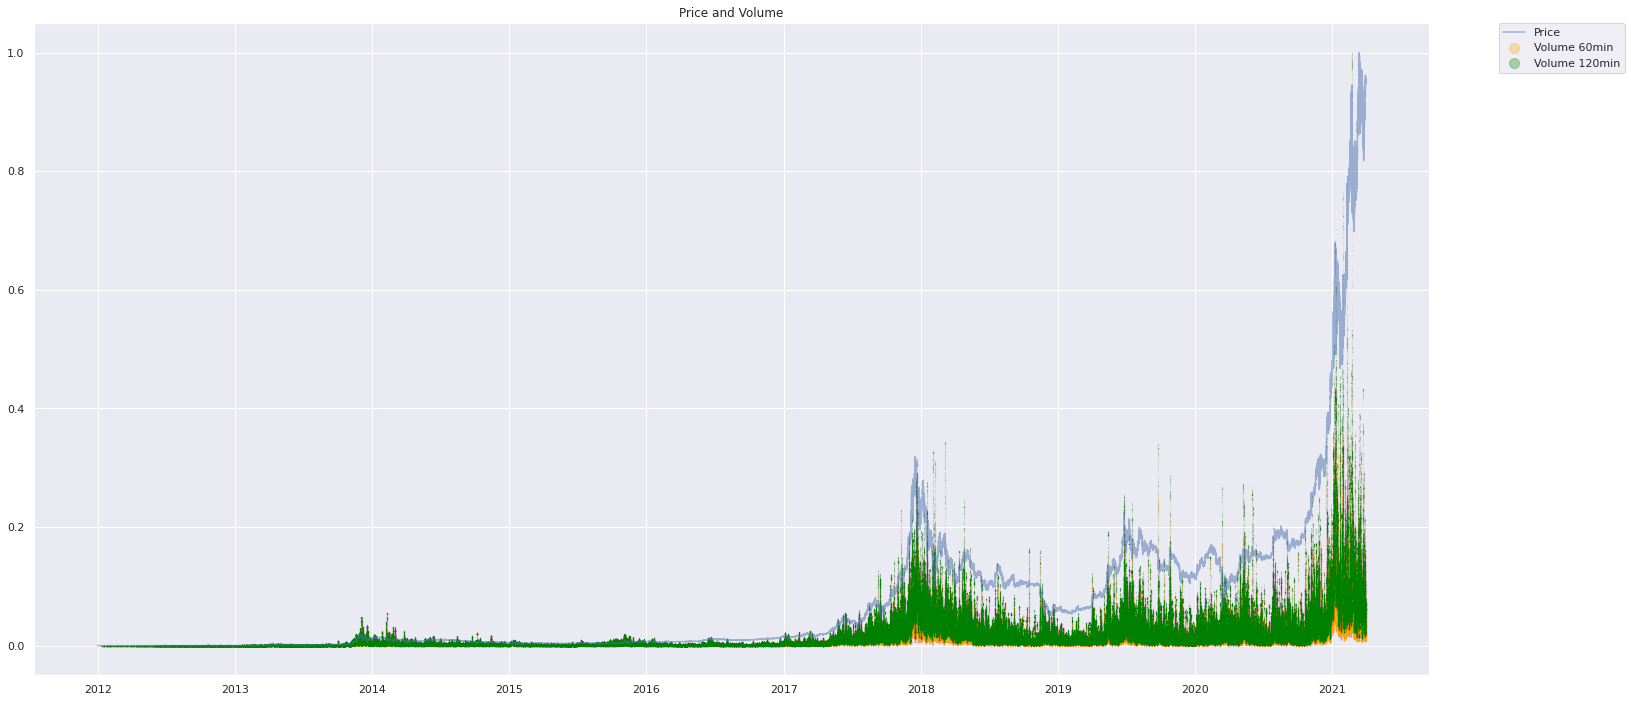

In [ ]:
plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(25,12))
ax.plot(df.index, scaler.fit_transform(df.Weighted_Price.values.reshape(-1,1)), alpha=0.5, label='Price')
ax.scatter(df.index, scaler.fit_transform(df.Vol_MA60.values.reshape(-1,1)), alpha=0.3, label='Volume 60min', s=0.01, color='orange')


ax.scatter(df.index, scaler.fit_transform(df.Vol_MA120.values.reshape(-1,1)), alpha=0.3, label='Volume 120min', s=0.01, color='green')
# ax.scatter(df.index, scaler.fit_transform(df.Percentage_Return.values.reshape(-1,1)), alpha=0.3, label='Return percent', s=0.01, color='red')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=100)
ax.set_title("Price and Volume")
plt.draw()

From the graph above we can see that bitcoin price move along with Volume 120 min.


Histogram, boxplot and violin plot showing the distribution of opening price. From the graph we can see the opening price has reached a price close to $17,000. Any price beyond \$17000 counts as outliers because it happened not much. In most cases, the opening price will not exceed \$7000. But normally, the opening price of bitcoin is around \$1000. So we can tell that Bitcoin's opening price fluctuates very much,and most of them are sold at low prices.

In [ ]:
def triple_plot(x, title,c):
    fig, ax = plt.subplots(3,1,figsize=(25,10),sharex=True)
    sns.distplot(x, ax=ax[0],color=c)
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x, ax=ax[1],color=c)
    ax[1].set(xlabel=None)
    ax[1].set_title('Boxplot')
    sns.violinplot(x, ax=ax[2],color=c)
    ax[2].set(xlabel=None)
    ax[2].set_title('Violin plot')
    fig.suptitle(title, fontsize=30)
    plt.tight_layout(pad=3.0)
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


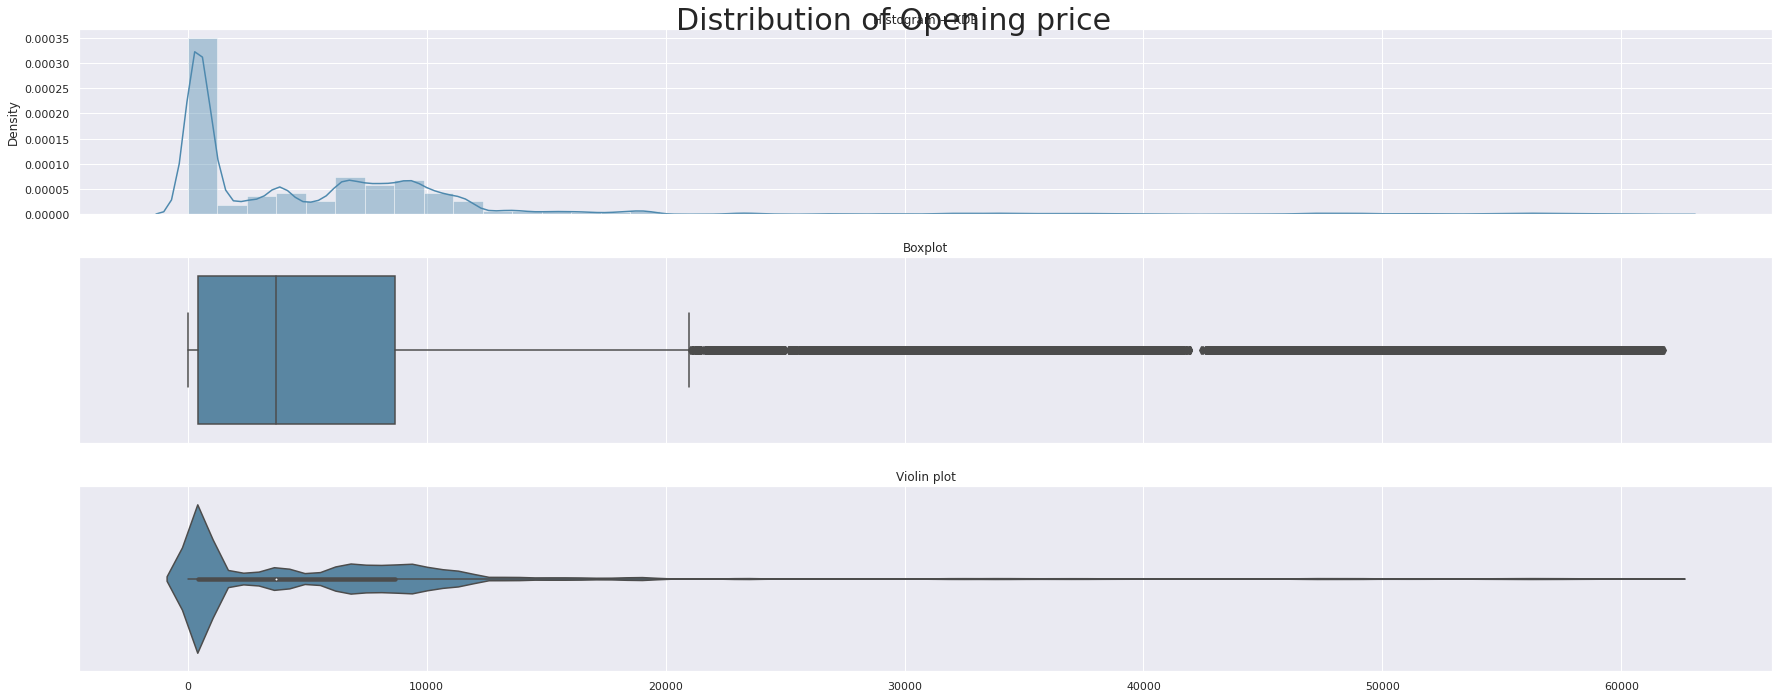

In [ ]:
triple_plot(df['Open'],'Distribution of Opening price',custom_colors[0])

We want to analyze if lagged time series will help to predict current bitcoin price. If there is a linear relationship, the prediction will work well.

We can see that there is a positive correlation for minute, hour and daily lag plots. We observe absolutely no correlation for month lag plots.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

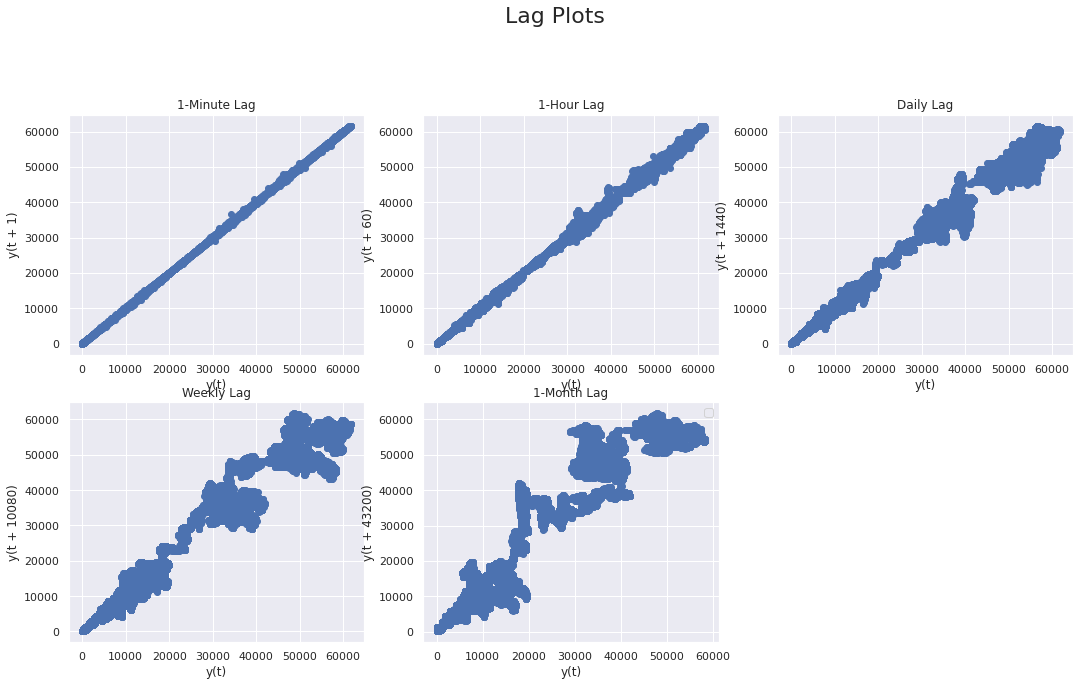

In [ ]:
plt.figure(figsize=(18,15))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(df['Weighted_Price'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(df['Weighted_Price'], lag=60) #hourley lag
plt.title('1-Hour Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(df['Weighted_Price'], lag=1440) #Daily lag
plt.title('Daily Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(df['Weighted_Price'], lag=10080) #weekly lag
plt.title('Weekly Lag')

plt.subplot(3,3,5)
pd.plotting.lag_plot(df['Weighted_Price'], lag=43200) #month lag
plt.title('1-Month Lag')

plt.legend()
plt.show()

In [ ]:
df_new = df[df.columns[:8]]
# Resampling to half day frequency
df_D = df_new.resample('12H').mean()

In [ ]:
df_D

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price
Timestamp,,,,,,,,
2011-12-31 00:00:00,4.390000,4.390000,4.390000,4.390000,0.455581,2.000000,4.390000,4.390000
2011-12-31 12:00:00,4.390000,4.390000,4.390000,4.390000,48.000000,210.720000,4.390000,4.390000
2012-01-01 00:00:00,4.580000,4.580000,4.580000,4.580000,1.502000,6.879160,4.580000,4.580000
2012-01-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-03-29 00:00:00,56065.928713,56095.552182,56040.122881,56068.396755,3.263724,184883.373614,56067.219784,56067.500133
2021-03-29 12:00:00,57758.664056,57791.219319,57725.168125,57757.188875,4.133570,238740.451105,57755.389641,57758.060094
2021-03-30 00:00:00,57866.947755,57893.064519,57842.906388,57870.565384,2.693399,156695.138910,57867.096245,57868.371011


In [ ]:
# Resampling to half day frequency
df_D = df_new.resample('12H').mean()

# Resampling to weekly frequency
df_W = df_new.resample('W').mean()

# Resampling to quarterly frequency
df_month = df.resample('3M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

In [ ]:
def fill_missing(df_D):
    ### function to impute missing values using interpolation ###
    df_D['Open'] = df_D['Open'].interpolate()
    df_D['Close'] = df_D['Close'].interpolate()
    df_D['High'] = df_D['High'].interpolate()
    df_D['Low'] = df_D['Low'].interpolate()
    df_D['Weighted_Price'] = df_D['Weighted_Price'].interpolate()
    df_D['Price'] = df_D['Price'].interpolate()
    df_D['Volume_(BTC)'] = df_D['Volume_(BTC)'].interpolate()
    df_D['Volume_(Currency)'] = df_D['Volume_(Currency)'].interpolate()

fill_missing(df_D)
fill_missing(df_W)
fill_missing(df_month)
fill_missing(df_year)

In [ ]:
df_D.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6757 entries, 2011-12-31 00:00:00 to 2021-03-31 00:00:00
Freq: 12H
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               6757 non-null   float64
 1   High               6757 non-null   float64
 2   Low                6757 non-null   float64
 3   Close              6757 non-null   float64
 4   Volume_(BTC)       6757 non-null   float64
 5   Volume_(Currency)  6757 non-null   float64
 6   Weighted_Price     6757 non-null   float64
 7   Price              6757 non-null   float64
dtypes: float64(8)
memory usage: 475.1 KB


Check the average price of each month after 2016. Usually March and February have highest bitcoin prices.

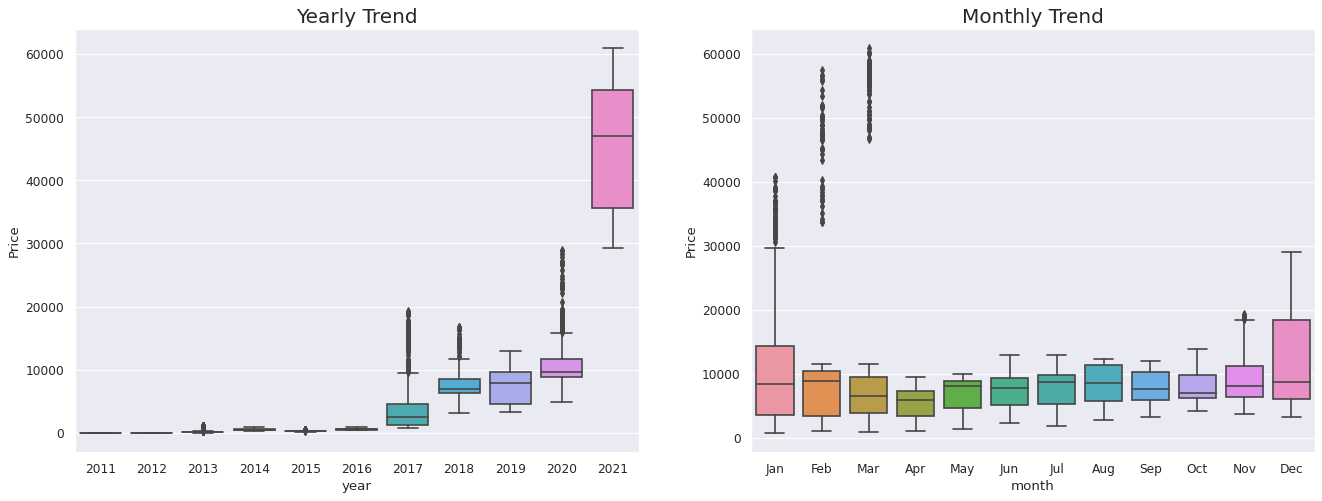

In [ ]:
df_D['year'] = [d.year for d in df_D.index]
df_D['month'] = [d.strftime('%b') for d in df_D.index]
years = df_D['year'].unique()


fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='Price', data=df_D, ax = axes[0])  
sns.boxplot(x='month', y='Price', data=df_D.loc[df_D.year.isin(list(range(2017,2022)))], ax= axes[1])


axes[0].set_title('Yearly Trend', fontsize=18); 
axes[1].set_title('Monthly Trend', fontsize=18);

In [ ]:
df_D[df_D['year'] > 2016].groupby('month').Price.mean().sort_values(ascending = False)

month
Mar    14988.888932
Feb    13935.280757
Jan    12070.177134
Dec    11893.472123
Nov     9505.120605
Aug     8192.041344
Oct     7975.727248
Sep     7780.207449
Jul     7451.283937
Jun     7055.918113
May     6695.697963
Apr     5377.923475
Name: Price, dtype: float64

According to the above two boxplots, the left one shows the yearly trend of the 
bitcoins price, and we can see that from 2011 to 2016, the price almost had no change. Since 2017, the price started to increase and there was a rapid growth from 2020 to 2021. In addition, the maximum fluctutations in prices occurred in 2021.

From the right plot, the highest mean value happened at the first quarter of the year and the lowest mean value appeared at the fourth quarter of each year. In addition, there were more outliers which was way higher than the mean values of each month appeared during the first quarter.

# **Logistics Regression**

Half Day Price Prediction Using Logistic Regression

In [ ]:
df_D.loc[:, 'Next_Price'] = df_D['Price'].shift(-1)

df_D.loc[(df_D['Price'] > df_D['Next_Price']), 'Trend'] = 0
df_D.loc[(df_D['Price'] < df_D['Next_Price']), 'Trend'] = 1

df_D.drop(df.index[-1], axis=0, inplace=True) 

Clear NaN for df_D

In [ ]:
def fill_missing(df_D):
    ### function to impute missing values using interpolation ###
    df_D['Open'] = df_D['Open'].interpolate()
    df_D['Close'] = df_D['Close'].interpolate()
    df_D['High'] = df_D['High'].interpolate()
    df_D['Low'] = df_D['Low'].interpolate()
    df_D['Weighted_Price'] = df_D['Weighted_Price'].interpolate()
    df_D['Price'] = df_D['Price'].interpolate()
    df_D['Volume_(BTC)'] = df_D['Volume_(BTC)'].interpolate()
    df_D['Volume_(Currency)'] = df_D['Volume_(Currency)'].interpolate()

fill_missing(df_D)
fill_missing(df_W)
fill_missing(df_month)
fill_missing(df_year)

In [ ]:
df_D.dropna(inplace = True)

Define variables.

In [ ]:
# Predictor X
X = df_D.drop(["Trend", 'Volume_(BTC)', 'Weighted_Price','Next_Price','month'],  axis = 1)
X.shape

(6755, 7)

In [ ]:
# Response y
y = df_D['Trend']
y.shape

(6755,)

In [ ]:
# Split the test and train sets 
# Use a 20% split for test.
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=888)

In [ ]:
len(Xtrain), len(Xtest), len(ytrain), len(ytest)

(5404, 1351, 5404, 1351)

In [ ]:
# Fit model to the training data:
model.fit(Xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Predict the test set
y_model = model.predict(Xtest)

In [ ]:
test = Xtest.join(ytest).reset_index()
test.join(pd.Series(y_model, name = 'predicted trend')).sort_values('Timestamp').reset_index().drop('index', axis = 1)

,Timestamp,Open,High,Low,Close,Volume_(Currency),Price,year,Trend,predicted trend
0,2012-01-01 00:00:00,4.580000,4.580000,4.580000,4.580000,6.879160,4.580000,2012,1.0,1.0
1,2012-01-01 12:00:00,4.720000,4.720000,4.720000,4.720000,36.332773,4.720000,2012,1.0,1.0
2,2012-01-09 12:00:00,6.610833,6.610833,6.610833,6.610833,12.492238,6.610833,2012,0.0,1.0
3,2012-01-10 12:00:00,6.655789,6.655789,6.655789,6.655789,14.010519,6.655789,2012,1.0,1.0
4,2012-01-15 00:00:00,7.150000,7.150000,7.150000,7.150000,9.428704,7.150000,2012,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1346,2021-03-22 12:00:00,56188.363468,56233.328315,56139.159457,56185.552423,375928.120597,56186.600916,2021,0.0,1.0
1347,2021-03-25 00:00:00,52554.357312,52592.752173,52515.702535,52554.826295,184007.567104,52554.409579,2021,0.0,1.0
1348,2021-03-26 12:00:00,53770.366264,53803.715736,53741.468667,53774.297583,195360.169663,53772.462063,2021,1.0,1.0
1349,2021-03-28 12:00:00,55594.276523,55621.849513,55567.937663,55596.020584,95597.784687,55595.021071,2021,1.0,1.0


In [ ]:
# Check the accuracy of this model
accuracy_score(ytest, y_model)

0.5344189489267209

In [ ]:
# Check the sensitivity of this model
TP = sum((ytest == 1) & (y_model == 1))
P = sum(ytest == 1)
TP / P

0.9807162534435262

In [ ]:
# Check the Specificity of this model
NP = sum((ytest == 0) & (y_model == 0))
N = sum(ytest == 0)
NP / N

0.016

# **Gaussian Naive Bayes**

In [ ]:
model_g = GaussianNB()
model_g.fit(Xtrain, ytrain)
y_model_g = model_g.predict(Xtest)

In [ ]:
Xtest = Xtest.join(ytest, sort = True).reset_index()
Xtest.join(pd.Series(y_model_g, name = 'predicted_trend'))

,Timestamp,Open,High,Low,Close,Volume_(Currency),Price,year,Trend,predicted_trend
0,2012-01-01 00:00:00,4.580000,4.580000,4.580000,4.580000,6.879160,4.580000,2012,1.0,1.0
1,2012-01-01 12:00:00,4.720000,4.720000,4.720000,4.720000,36.332773,4.720000,2012,1.0,1.0
2,2012-01-09 12:00:00,6.610833,6.610833,6.610833,6.610833,12.492238,6.610833,2012,0.0,1.0
3,2012-01-10 12:00:00,6.655789,6.655789,6.655789,6.655789,14.010519,6.655789,2012,1.0,1.0
4,2012-01-15 00:00:00,7.150000,7.150000,7.150000,7.150000,9.428704,7.150000,2012,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1346,2021-03-22 12:00:00,56188.363468,56233.328315,56139.159457,56185.552423,375928.120597,56186.600916,2021,0.0,1.0
1347,2021-03-25 00:00:00,52554.357312,52592.752173,52515.702535,52554.826295,184007.567104,52554.409579,2021,0.0,1.0
1348,2021-03-26 12:00:00,53770.366264,53803.715736,53741.468667,53774.297583,195360.169663,53772.462063,2021,1.0,1.0
1349,2021-03-28 12:00:00,55594.276523,55621.849513,55567.937663,55596.020584,95597.784687,55595.021071,2021,1.0,1.0


In [ ]:
# Check the accuracy of this model
sum(y_model_g == ytest) / len(ytest)

0.53960029607698

In [ ]:
# Check the sensitivity of this model
TP = sum((ytest == 1) & (y_model_g == 1))
P = sum(ytest == 1)
TP / P

0.9628099173553719

In [ ]:
# Check the Specificity of this model
NP = sum((ytest == 0) & (y_model_g == 0))
N = sum(ytest == 0)
NP / N

0.048

Our Gaussian Naive Bayes model shows the model accuracy at 53.96%, which is slightly higher than the Logistic Regression model(53.44%).

Moreover, both Logistics Regression and Gaussian Naive Bayes model have a high sensitivity and low specificity, which means both model predict the upward movement at a high correct rate, but predict the downward direction at a pretty low correct rate.

However, these two models are not good enough to predict the bitcoins price, since they don't capture any other impacts such as, seasonality, trend, and intrinsic factors.

# **ARIMA Model**

Arima model stands for Auto Regressive Intergrated Moving Average. It is a forcasting algorimth that uses the past values to predict future values such as intercept (c), Lags (AR), forecast errors (MA).

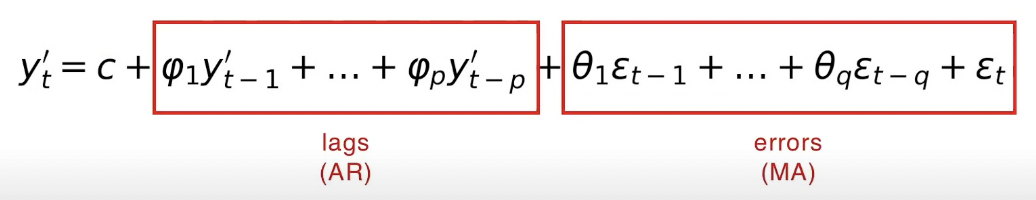

In [ ]:
df = df.resample("24H").mean()

In [ ]:
df= df[["Close"]].copy()

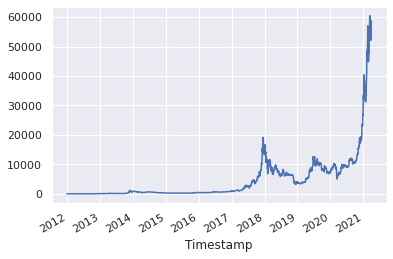

In [ ]:
#drop any missing values for closing columns 
df.Close.dropna().plot()

We split the group into two inorder to calculate the mean and variance of the two groups. If the mean and variance looks very different, our data is non-stationary time series so we cannot reject the null. A non- stationary time series is one that depends on time at which the series is observed.

In [ ]:
# use log to make the distribution more flat.
X = df.Close
X=log(X)
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=4.846853, mean2=8.641394
variance1=2.772653, variance2=1.048936


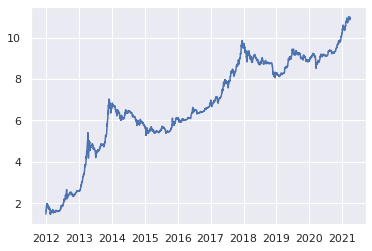

In [ ]:
#plot a graph after using log to flatten the closing price 
plt.plot(X)
plt.show()

Another way to see if our data is stationary by using adfuller() function. The function perform ADF test.
Null hypothesis of ADF is that the time series is not stationary. So if P-value is bigger than 0.05. we cannot reject Null.
Augmented Dickey Fuller test

In [ ]:
# d=0 if the time series is stationary 
test_adf = adfuller(df.Close.dropna())

print(f" ADF Statistics: {test_adf[0]}")
print(f" P-value: {test_adf[1]}")

 ADF Statistics: 6.175631275785332
 P-value: 1.0


The P-value that we got showed that the time series is 100% non- staitonary. So We are going to tranform the non- stationary data by taking the differences of consecutive observations.

In [ ]:
#use Pandas's diff()
df["diff_1"] = df["Close"].diff(periods=1)
df["diff_2"] = df["Close"].diff(periods=2)
df["diff_3"] = df["Close"].diff(periods=3)

df.head(6)

,Close,diff_1,diff_2,diff_3
Timestamp,,,,
2011-12-31,4.390000,NaN,NaN,NaN
2012-01-01,4.580000,0.190000,NaN,NaN
2012-01-02,5.000000,0.420000,0.610000,NaN
2012-01-03,5.290000,0.290000,0.710000,0.900000
2012-01-04,5.157500,-0.132500,0.157500,0.577500
2012-01-05,6.358182,1.200682,1.068182,1.358182


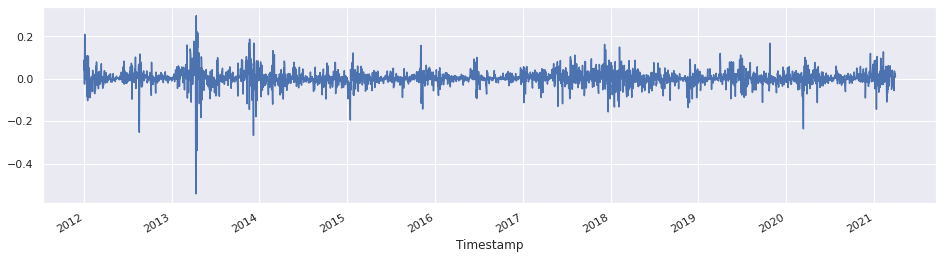

In [ ]:
#use log to remove non-linearity 
transformed_df = pd.Series(log(df["Close"])).diff().dropna()

transformed_df.plot(figsize=(16, 4))

The time series is now more stationary.

In [ ]:
#run the adf test with modified data 
results = adfuller(transformed_df)

print(f" ADF Statistics: {results[0]}")
print(f" P-value: {results[1]}")

 ADF Statistics: -10.581531220927875
 P-value: 6.885531281585583e-19


**Hyperparameter Tuning**

Hyperparameter of Arima Model are P,d and q. P refers to the order of the autoregressive term. d refers to the numbers of differences inorder to make the time series stationary. q is the order of the moving average term.

**Finding d**

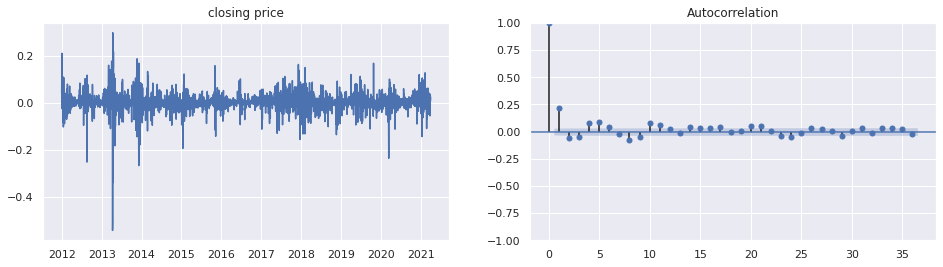

In [ ]:
#order of differencing #2nd diff 
fig, (ax1, ax2)= plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(transformed_df)
ax1.set_title('closing price')
plot_acf(transformed_df, ax= ax2);

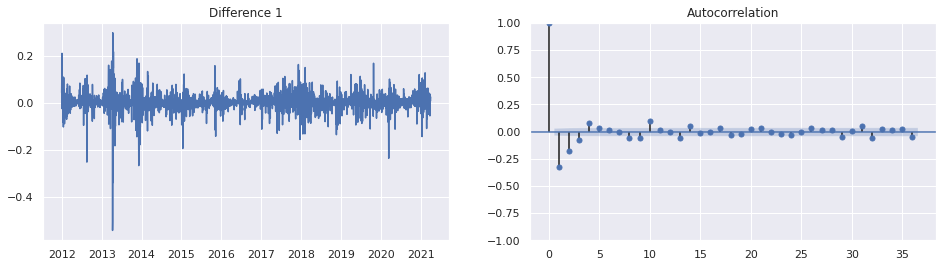

In [ ]:
#3rd fiff
diff3 = transformed_df.diff().dropna()

fig, (ax1, ax2)= plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(transformed_df)
ax1.set_title('Difference 1')
plot_acf(diff3, ax= ax2);

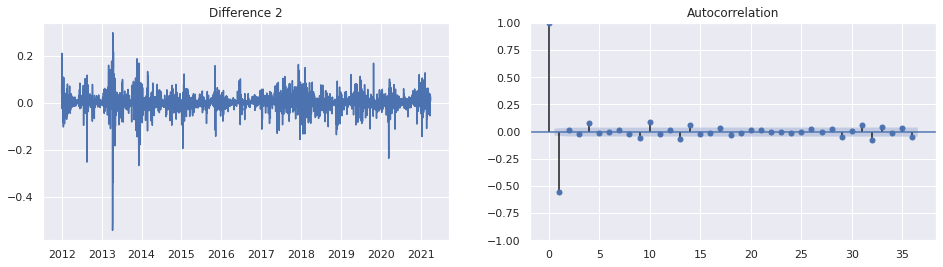

In [ ]:
#4th difference 
diff4 = transformed_df.diff().diff().dropna()

fig, (ax1, ax2)= plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(transformed_df)
ax1.set_title('Difference 2')
plot_acf(diff4, ax= ax2);

The time series reaches stationary after one differencing because the autocorrolation plot for the 3rd differencing, the lag went into the negative zone. This indicates that the series might have been overdifferenced.

Therefore, we can have d=1

To make sure that the interpretation is correct, we're going to use ndiff() package to find d value

In [ ]:
ndiffs(df.Close.dropna(), test="adf") #deciding d for order of differencing 

1

**Find p**

Using Partial Correlation Plot to find p. Partial Auto correlation represent the correlation between the series and its lags.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


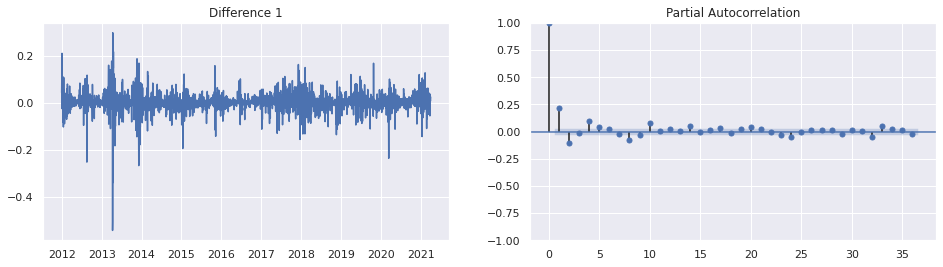

In [ ]:
#plot PACF # first difference 
diff_p = log(df.Close).diff().dropna()

fig, (ax1, ax2)= plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(diff_p)
ax1.set_title('Difference 1')
ax2.set_ylim(0, 5)
plot_pacf(diff_p, ax= ax2);

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


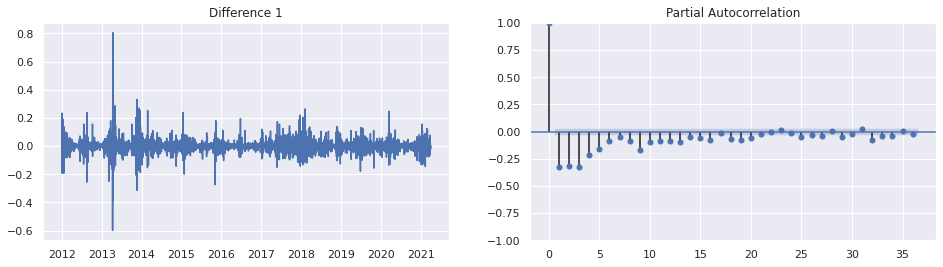

In [ ]:
#plot PACF # first difference 
diff_p2 = log(df.Close).diff().diff().dropna()

fig, (ax1, ax2)= plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(diff_p2)
ax1.set_title('Difference 1')
ax2.set_ylim(0, 5)
plot_pacf(diff_p2, ax= ax2);

We can observe that the PACF lag is as it's above the significant line and stoof out the most.

**Finding q**

q is the order of the moving average (MA)term. Its the number of lagged forecast errors that should go into the ARIMA model We also use ACF plot to find q

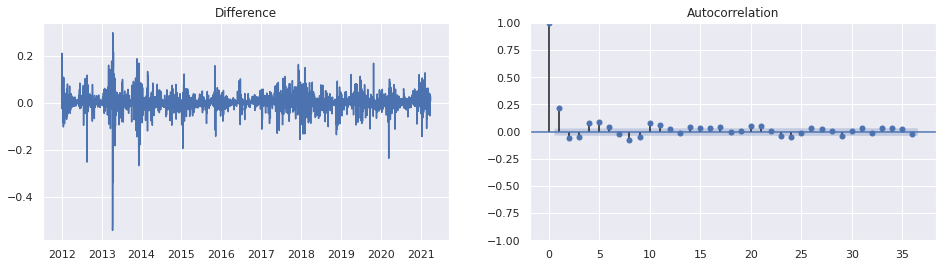

In [ ]:
#first difference
diff_q= log(df.Close).diff().dropna()

fig, (ax1, ax2)= plt.subplots(1, 2, figsize= (16, 4))

ax1.plot(diff_q)
ax1.set_title('Difference')
ax2.set_ylim(0, 1)
plot_acf(diff_q, ax= ax2);

From observation, we can see the forecast error is about 7 (Right at the shaded area)

# **Fitting the models with ARIMA function**

In [ ]:
#fitting the arima model 
# ARIMA model 
model = ARIMA(df.Close, order=(1,2,7))
model_fit = model.fit()
print(model_fit.summary()) 

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3379
Model:                 ARIMA(1, 2, 7)   Log Likelihood              -24597.018
Date:                Tue, 05 Oct 2021   AIC                          49212.036
Time:                        18:57:14   BIC                          49267.158
Sample:                    12-31-2011   HQIC                         49231.744
                         - 03-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4577      0.314      1.459      0.145      -0.157       1.073
ma.L1         -1.2766      0.314     -4.066      0.000      -1.892      -0.661
ma.L2          0.1964      0.258      0.761      0.4

The summary displayed the predictors and coeficient for the model. For predictors with P-value more than 0.05, they will have no significance in the model.

There are 7 MA values and 1 AR in the model.

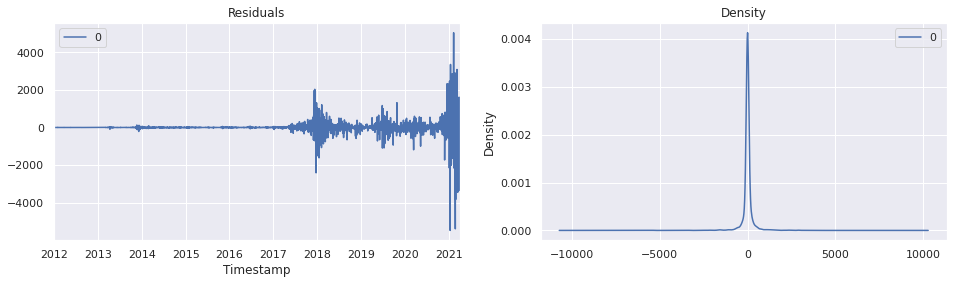

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1, 2, figsize= (16, 4))

residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
 #dont run this cell if there's no error messgae from the cell above
 !pip install statsmodels --upgrade

**Splitting train and test sets**

In [ ]:
#splitting the dataset into 80:20 ratio 
n= int(len(df.Close)*0.8)
train_set= df.Close[:n]
test_set= df.Close[n:]

In [ ]:
print(len(train_set))
print(len(test_set))

2703
676


In [ ]:
#fitting into the train set 
model_train= ARIMA(train_set, order= (1,2,7))
result_train = model_train.fit()

In [ ]:
result_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2703
Model:                 ARIMA(1, 2, 7)   Log Likelihood              -17578.105
Date:                Tue, 05 Oct 2021   AIC                          35174.211
Time:                        18:57:33   BIC                          35227.323
Sample:                    12-31-2011   HQIC                         35193.417
                         - 05-25-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8405      0.012    -67.278      0.000      -0.865      -0.816
ma.L1          0.0523      0.018      2.884      0.004       0.017       0.088
ma.L2         -0.8126      0.015    -54.473      0.000      -0.842      -0.783
ma.L3         -0.2196      0.009    -24.526      0.000      -0.237      -0.202
ma.L4         -0.0437      0.006     -7.848      0.000      -0.055      -0.033
ma.L5          0.0383      0.008      4.648      0.000       0.022       0.054
ma.L6          0.0648      0.005     12.856      0.000       0.055       0.075
ma.L7         -0.0794      0.006    -12.778      0.000      -0.092      -0.067
sigma2      2.747e+04    288.318     95.264      0.000    2.69e+04     2.8e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            253725.51
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):             234.52   Skew:                             0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        50.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#fitting into the test set 
model_test= ARIMA(test_set, order= (1,2,7))
result_test = model_test.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
result_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  676
Model:                 ARIMA(1, 2, 7)   Log Likelihood               -5401.332
Date:                Tue, 05 Oct 2021   AIC                          10820.664
Time:                        18:57:37   BIC                          10861.284
Sample:                    05-26-2019   HQIC                         10836.394
                         - 03-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8935      0.025    -36.336      0.000      -0.942      -0.845
ma.L1          0.1118      0.029      3.843      0.000       0.055       0.169
ma.L2         -0.9184      0.035    -25.952      0.000      -0.988      -0.849
ma.L3         -0.2504      0.024    -10.271      0.000      -0.298      -0.203
ma.L4          0.0343      0.031      1.098      0.272      -0.027       0.095
ma.L5          0.1322      0.030      4.421      0.000       0.074       0.191
ma.L6         -0.0717      0.023     -3.119      0.002      -0.117      -0.027
ma.L7         -0.0114      0.025     -0.459      0.646      -0.060       0.037
sigma2      5.659e+05   1.28e+04     44.308      0.000    5.41e+05    5.91e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              7483.03
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):              12.13   Skew:                            -0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#forecast 3 steps 
steps =3

fc, se, conf = result_test.forecast(steps)

In [ ]:
# out of sample forecast
print(fc)

58621.62739321415


The forcasted price for Bitcoin is 58859.6212 $

In [ ]:
# standard error of the forecast 
print(se)

59026.703571673235


In [ ]:
#upper bound and lower bound confidence level 
print(conf)

59207.64211527481


In [ ]:
#create a pandas dataframe for the variables 
fc = pd.Series(fc, index= test_set.index)
lower = pd.Series(conf, index= test_set.index)
upper = pd.Series(conf, index= test_set.index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Unrecognized location 'Upper Left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # Remove the CWD from sys.path while we load stuff.


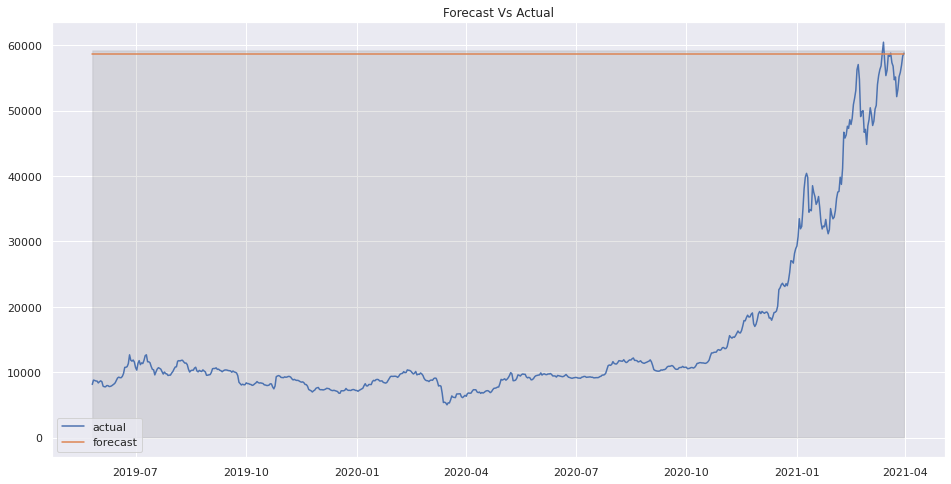

In [ ]:
#plotting forcast values and test set 
plt.figure(figsize=(16, 8))
plt.plot(test_set, label= "actual")
plt.plot(fc, label= "forecast")


plt.fill_between(lower.index, upper, color= "k", alpha= 0.1)

plt.title("Forecast Vs Actual")
plt.legend(loc= "Upper Left")

The conclusion that we drew from this model is that it is not practical with stock price dataset. The dataset itself is non- stationary so it is harder to run the model without having to modify the data. The forcasts cannot predicted more than 3 steps and the splitting of the data is not evenly distributed into train and test set. The test set's closing price are much higher as the price of bitcoin increase over time. 

#**Simple RNN**

In [ ]:
df_RNN = pd.read_csv("/content/drive/MyDrive/bitcoin.csv")

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
df_RNN["Date"] = pd.to_datetime(df_RNN["Timestamp"],unit="s").dt.date
df_RNN = df_RNN.groupby("Date").mean()

In [ ]:
Real_Price = df_RNN.groupby('Date')['Weighted_Price'].mean()

Split the dataset, take the data of last 30 days as the test set

In [ ]:
prediction_days = 30
df_train = Real_Price[:len(Real_Price)-prediction_days]
df_test = Real_Price[len(Real_Price)-prediction_days:]

Data preprocess

In [ ]:
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
training_set = scaler.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))


Build the SimpleRNN model by using Keras and choose some appropriate parameters.

In [ ]:
regressor=Sequential()
#first RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True,input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.25))
#second RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#third RNN layer
regressor.add(SimpleRNN(512,activation="relu",return_sequences=True))
regressor.add(Dropout(0.35))
#fourth RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#fifth RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#convert the matrix to 1-line
regressor.add(Flatten())
#output layer
regressor.add(Dense(1))

regressor.compile(optimizer="adam",loss="mean_squared_error")
regressor.fit(X_train,y_train,epochs=100,batch_size=64)

Epoch 1/100
53/53 [==============================] - 5s 28ms/step - loss: 0.0021
Epoch 2/100
53/53 [==============================] - 1s 28ms/step - loss: 9.9033e-04
Epoch 3/100
53/53 [==============================] - 1s 28ms/step - loss: 9.7079e-04
Epoch 4/100
53/53 [==============================] - 1s 27ms/step - loss: 7.2688e-04
Epoch 5/100
53/53 [==============================] - 2s 28ms/step - loss: 9.8075e-04
Epoch 6/100
53/53 [==============================] - 2s 30ms/step - loss: 8.5672e-04
Epoch 7/100
53/53 [==============================] - 3s 55ms/step - loss: 7.8183e-04
Epoch 8/100
53/53 [==============================] - 3s 50ms/step - loss: 6.6896e-04
Epoch 9/100
53/53 [==============================] - 2s 46ms/step - loss: 0.0011
Epoch 10/100
53/53 [==============================] - 1s 27ms/step - loss: 6.7325e-04
Epoch 11/100
53/53 [==============================] - 1s 26ms/step - loss: 0.0010
Epoch 12/100
53/53 [==============================] - 1s 26ms/step - loss: 

Choose 100 layers, caculate the MSE of the 100 layers.

Accroding to the loss, we found out the minimum MSE is 3.7816e-04 (64th epoch).


Making the predictions by setting inputs and predict values.

In [ ]:
test_set = df_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = scaler.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = scaler.inverse_transform(predicted_BTC_price)

Visualising the results

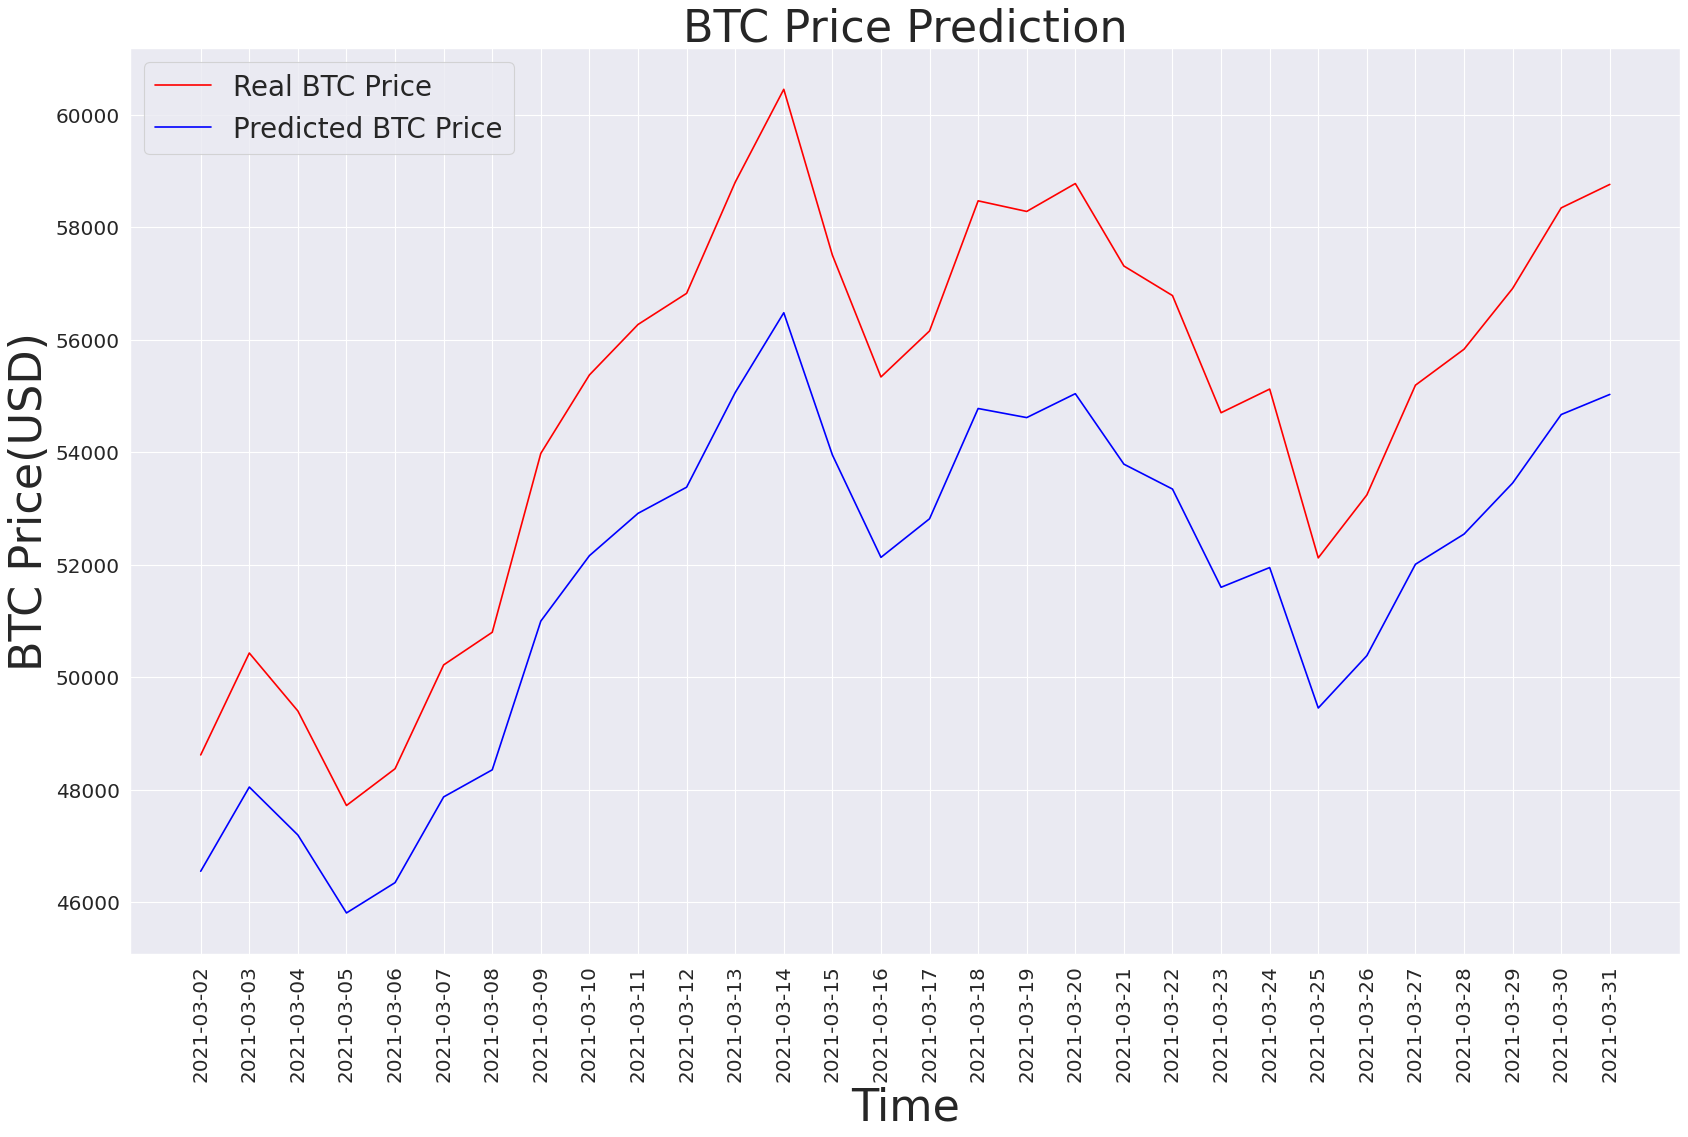

In [ ]:
plt.figure(figsize = (25,15), dpi = 80, facecolor = 'w', edgecolor = 'k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize = 40)
df_test = df_test.reset_index()
x = df_test.index
labels = df_test['Date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize = 40)
plt.ylabel('BTC Price(USD)', fontsize = 40)
plt.legend(loc = 2, prop = {'size': 25})
plt.show()

Since the minimum MSE is 3.7816e-04 and as the prediction result graph, Simple RNN is a relatively good fit to predict Bitcoin price. However, we notice there is a vertical shift from the predicted price to the real price. We believe this is caused by the event driven factors on news. 

#**LSTM Model**

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/bitcoin.csv")

In [ ]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
bitcoin=df
bitcoin['price'] = (bitcoin['High']+ bitcoin['Low'])/2
bitcoin.drop(['Open','Close','Volume_(BTC)','Volume_(Currency)', 'Weighted_Price','High','Low'],axis=1, inplace=True)

bitcoin['Timestamp'] = pd.to_datetime(bitcoin['Timestamp'],unit='s')
bitcoin = bitcoin.set_index('Timestamp')
bitcoin = bitcoin.resample('6H').mean()
bitcoin = bitcoin.dropna()

KeyError: ignored

Using Scalar to get values in 0's and 1's for price

In [ ]:
price = scaler.fit_transform(np.array(bitcoin['price']).reshape(-1,1))
bitcoin['price'] = price

Testing 1 date based on what done above to check if code works. In this test I will predict price for 1 date based on price of 100 dates.

In [ ]:
X_l = []
y_l = []
Number = len(bitcoin)
Dates = 100
for i in range(Number-Dates-1):
    X_l.append(bitcoin.iloc[i:i+Dates])
    y_l.append(bitcoin.iloc[i+Dates])
    
X = np.array(X_l)
y = np.array(y_l)

print(X.shape, y.shape)

# 12646 is the price for 1 day based on 100 days

(13275, 100, 1) (13275, 1)


Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state= 100)


Model for Overall Dataset

In [ ]:
m_x = layers.Input(shape = X_train.shape[1:])
m_h = layers.LSTM(10)(m_x)
m_y = layers.Dense(1)(m_h)
m = models.Model(m_x,m_y)
m.compile('adam','mse')
m.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 1)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


Evaluate model (100 times)

In [ ]:
history = m.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test),verbose=0)

Show Model

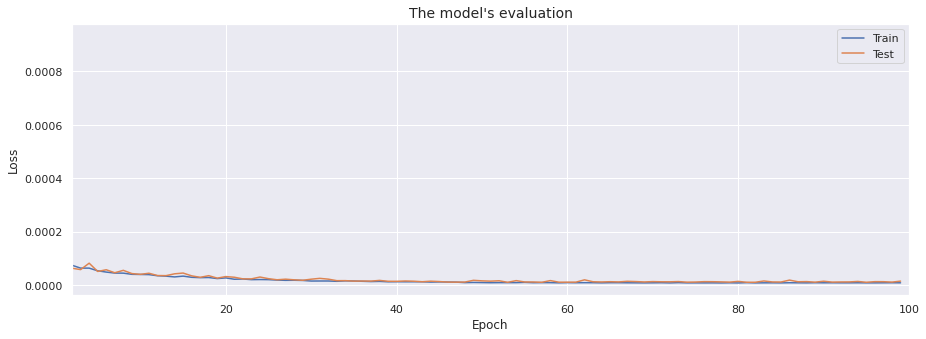

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train','Test'])
plt.title("The model's evaluation", fontsize=14)
plt.xlabel('Epoch')
plt.xlim(2,100)
plt.ylabel('Loss')
plt.show()

Predict price on 200 values

In [ ]:
pred =[]

pr = m.predict(np.array(bitcoin[-40:]))

pred.append(pr[0])

for i in range(1,40):
    pr = m.predict(np.concatenate((np.array(bitcoin[-40+i:]), pred[:]), axis=0))
    pred.append(pr[0])

for i in range(0,160):
    pr = m.predict(np.concatenate(pred[i:],axis=0).reshape(-1,1))
    pred.append(pr[0])

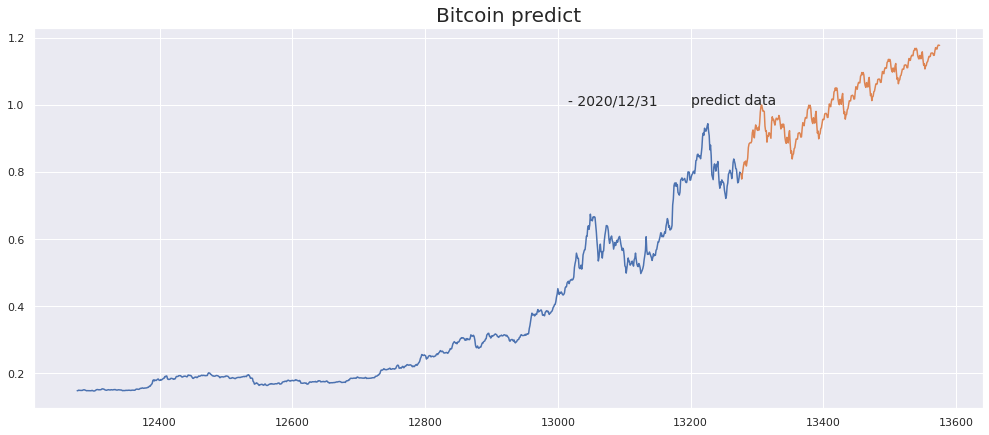

In [ ]:
pred = pd.DataFrame(pred)

pred = pred.reset_index()

pred.columns = ['z','price']

pred.drop(['z'],axis=1,inplace=True)

data = pd.concat([bitcoin.reset_index().drop('Timestamp',axis=1),pred],ignore_index=True)

plt.figure(figsize=(17,7))
plt.plot(data[-1300:-300])
plt.title("Bitcoin predict",fontsize=20)
plt.text(13200,1,"predict data",fontsize=14)
plt.text(13015,1,"- 2020/12/31",fontsize=14)
plt.plot(data[-300:])
plt.show()

When looking at the overall results, it is clear that we cannot predict the price of bitcoin with this model. But what if we break the model down to 2 parts and see if the results are better.

So we split the dataset into two parts. Part A is the LSTM model which only shows the dates before 2017

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/bitcoin.csv")

In [ ]:
df.head()

,Timestamp,price
0,1325317920,4.39
1,1325317980,NaN
2,1325318040,NaN
3,1325318100,NaN
4,1325318160,NaN


In [ ]:
parta = df
parta['price'] = (parta['High']+ parta['Low'])/2
parta.drop(['Open','Close','Volume_(BTC)','Volume_(Currency)', 'Weighted_Price','High','Low'],axis=1, inplace=True)
parta = parta.resample('6H').mean()
parta = parta.dropna()

parta = parta['2011-12-31 07:52:00' :'2016-12-31 23:59:59']

TypeError: ignored

Additional Information about the data for better understanding

In [ ]:
price = parta['price']
max_value = price.max()
min_value = price.min()
avg_value=price.mean()

print(max_value, ' is the maximum  price of bitcoin ')
print(min_value,  ' is the minimum price of bitcoin')
print(avg_value, 'is the average price of bitcoin')

61721.34  is the maximum  price of bitcoin 
3.8  is the minimum price of bitcoin
6008.922542558404 is the average price of bitcoin


In [ ]:
price = scaler.fit_transform(np.array(parta['price']).reshape(-1,1))
parta['price'] = price

In [ ]:
X_la = []
y_la = []
Number = len(parta)
Dates = 100
for i in range(Number-Dates-1):
    X_la.append(parta.iloc[i:i+Dates])
    y_la.append(parta.iloc[i+Dates])
    
X = np.array(X_la)
y = np.array(y_la)

print(X.shape, y.shape)


KeyboardInterrupt: ignored

Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state= 100)


LSTM Model for Part A Dataset

In [ ]:
m_x = layers.Input(shape = X_train.shape[1:])
m_h = layers.LSTM(10)(m_x)
m_y = layers.Dense(1)(m_h)
m = models.Model(m_x,m_y)
m.compile('adam','mse')
m.summary()

Evaluate model (100 times)

In [ ]:
history= m.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test),verbose=0)

Show model

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train','Test'])
plt.title("The model's evaluation", fontsize=14)
plt.xlabel('Epoch')
plt.xlim(2,100)
plt.ylabel('Loss')
plt.show()

Predict price on 200 values

In [ ]:
pred =[]

pr = m.predict(np.array(parta[-40:]))

pred.append(pr[0])

for i in range(1,40):
    pr = m.predict(np.concatenate((np.array(parta[-40+i:]), pred[:]), axis=0))
    pred.append(pr[0])

for i in range(0,160):
    pr = m.predict(np.concatenate(pred[i:],axis=0).reshape(-1,1))
    pred.append(pr[0])


Plot results

In [ ]:
pred = pd.DataFrame(pred)

pred = pred.reset_index()

pred.columns = ['z','price']

pred.drop(['z'],axis=1,inplace=True)

data = pd.concat([parta.reset_index().drop('Timestamp',axis=1),pred],ignore_index=True)

plt.figure(figsize=(17,7))
plt.plot(data[-1300:-300])
plt.title("Bitcoin predict",fontsize=20)
plt.text(13200,1,"predict data",fontsize=14)
plt.text(13015,1,"- 2020/12/31",fontsize=14)
plt.plot(data[-300:])
plt.show()

Part B is the LSTM model which only shows the dates after 2017

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/bitcoin.csv")

In [ ]:
partb = df

partb['price'] = (partb['High']+ partb['Low'])/2
partb.drop(['Open','Close','Volume_(BTC)','Volume_(Currency)', 'Weighted_Price','High','Low'],axis=1, inplace=True)

partb['Timestamp'] = pd.to_datetime(partb['Timestamp'],unit='s')

partb = partb.set_index('Timestamp')
partb = partb.resample('6H').mean()
partb = partb.dropna()

partb = partb['2017-01-01 00:00:00' :'2021-12-31 23:59:59']

View of what the data looks like in plt plot

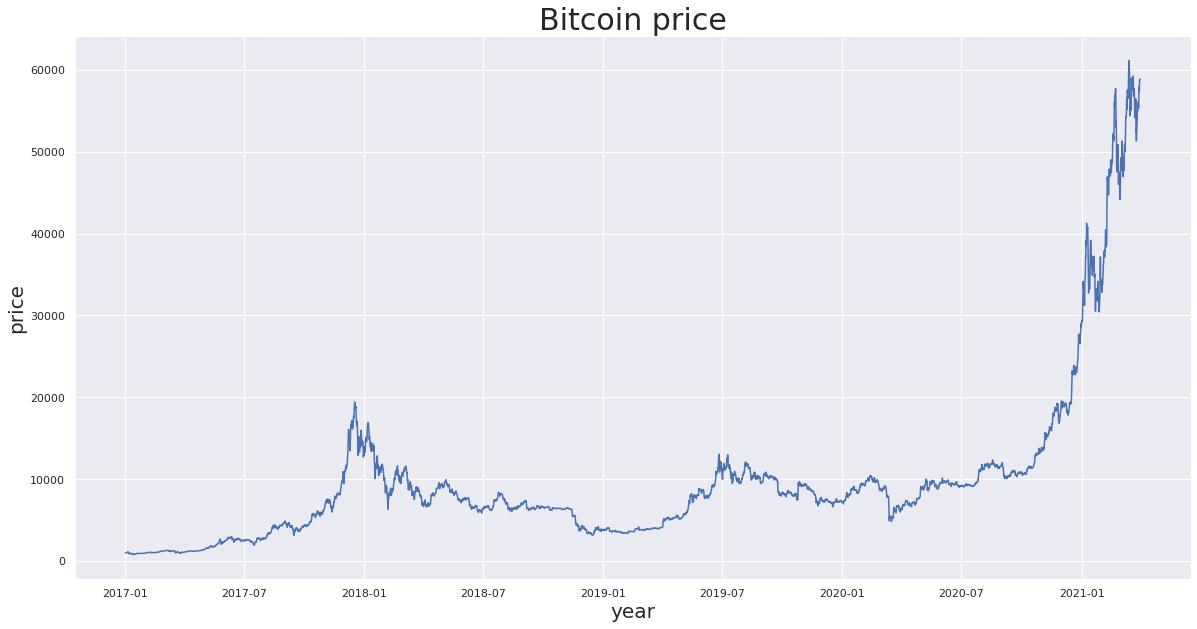

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(partb)
plt.title('Bitcoin price',fontsize=30)
plt.xlabel('year',fontsize=20)
plt.ylabel('price',fontsize=20)
plt.show()

Additional Information about the data for better understanding

In [ ]:
price = partb['price']
max_value = price.max()
min_value = price.min()
avg_value=price.mean()

print(max_value, ' is the maximum  price of bitcoin ')
print(min_value,  ' is the minimum price of bitcoin')
print(avg_value, 'is the average price of bitcoin')

61156.50703081235  is the maximum  price of bitcoin 
763.2702994011972  is the minimum price of bitcoin
9634.185899506574 is the average price of bitcoin



Using Scalar to get values in 0's and 1's for price

In [ ]:
price = scaler.fit_transform(np.array(partb['price']).reshape(-1,1))
partb['price'] = price


Testing 1 date based on what done above to check if code works. In this test I will predict price for 1 date based on price of 100 dates.

In [ ]:
X_lb = []
y_lb = []
Number = len(partb)
Dates = 100
for i in range(Number-Dates-1):
    X_lb.append(partb.iloc[i:i+Dates])
    y_lb.append(partb.iloc[i+Dates])
    
X = np.array(X_lb)
y = np.array(y_lb)

print(X.shape, y.shape)
# 7073 is the price for 1 day based on 100 days

(6100, 100, 1) (6100, 1)



Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state= 100)


LSTM Model for Part B Dataset

In [ ]:
m_x = layers.Input(shape = X_train.shape[1:])
m_h = layers.LSTM(10)(m_x)
m_y = layers.Dense(1)(m_h)
m = models.Model(m_x,m_y)
m.compile('adam','mse')
m.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 1)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________



Evaluate model (100 times)

In [ ]:
history= m.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test),verbose=0)


Show model

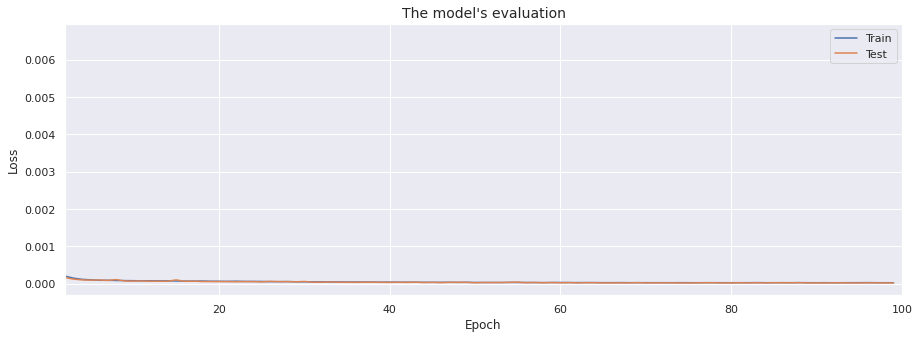

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train','Test'])
plt.title("The model's evaluation", fontsize=14)
plt.xlabel('Epoch')
plt.xlim(2,100)
plt.ylabel('Loss')
plt.show()

Predict price on 200 values

In [ ]:
pred =[]

pr = m.predict(np.array(partb[-40:]))

pred.append(pr[0])

for i in range(1,40):
    pr = m.predict(np.concatenate((np.array(partb[-40+i:]), pred[:]), axis=0))
    pred.append(pr[0])

for i in range(0,160):
    pr = m.predict(np.concatenate(pred[i:],axis=0).reshape(-1,1))
    pred.append(pr[0])

Plot results

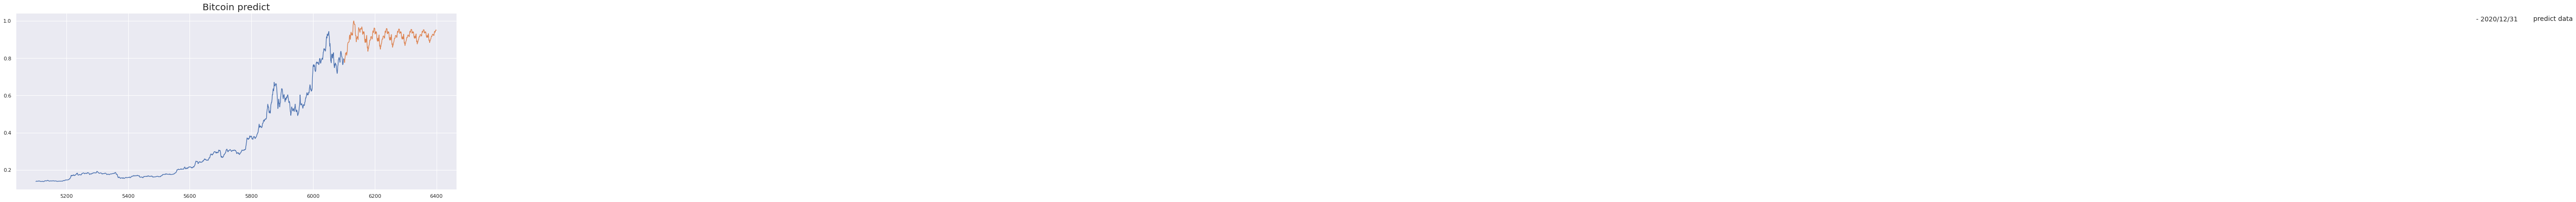

In [ ]:
pred = pd.DataFrame(pred)

pred = pred.reset_index()

pred.columns = ['z','price']

pred.drop(['z'],axis=1,inplace=True)

data = pd.concat([partb.reset_index().drop('Timestamp',axis=1),pred],ignore_index=True)

plt.figure(figsize=(17,7))
plt.plot(data[-1300:-300])
plt.title("Bitcoin predict",fontsize=20)
plt.text(13200,1,"predict data",fontsize=14)
plt.text(13015,1,"- 2020/12/31",fontsize=14)
plt.plot(data[-300:])
plt.show()

# **Conclusion**

By studying the time series data from 2011 to 2021, we found that early years' collection of the dataset is not complete across the internet. Only in recent years when bitcoin price boosts and shows up often in news encourage its data collection. Across the ten years, majority of bitcoin prices are between 0 to 10k dollars. Only the most recent years, the price of bitcoin boosts to 60k dollars. Also, The bitcoin price is correlated with 60min and 120min moving average trading volume as we see them move up and down together over the years. Bitcoin price is also highly correlated with 1 minute lag, better than 1 hour lag and better than daily lag to predict bitcoin price at current time. So it is extremely suitable for high frequency prediction and trading. In addtion, we found that usually bitcoin price is high in February and March, which may correlate with business cycles in the first quarter. 

By trying different machine learning models, including Logistics Regression, Gaussian Naive Bayes, ARIMA model, Simple RNN and LSTM, we noticed that Simple RNN performed the best with the smallest MSE to be 3.7816e-04. 